# PINO: Physics-Informed Neural Operator

## Solve
$$ \frac{d^2u(x)}{dx^2} = f(x) $$
$f(x)$: Given function  
$u(0)=u_0$, $u(1)=u_1$: Given boundary condition

### PINOの戦略
- PINNの場合は、与えられた$f(x)$, $u_0$, $u_1$などの条件に従うように、その都度関数 $u(x)$ を表すニューラルネットワークのハイパーパラメータ $\theta$ を学習（方程式を満たすように調整）していた。→ 条件が変わると学習し直し。
- 通常のニューラルネットワークは、入力として与えられた数値の組（例えば $f(x) = \sin(x)$, $u_0=0$, $u_1=1$）に対しする出力の数値の組 $u(x)=...$ を与える、いわゆる関数：数 → 数を学習するのに対し、作用素学習の考え方では、具体的な数値ではなく、入力関数 $f$ と出力関数 $u$ の間に関数同士の変換関係、いわゆる作用素：関数 → 関数の関係があるとして、その作用素を表現するようなネットワークをニューラルオペレータという構造で表す（表そうと頑張っている）
- PINOは作用素学習を用いたPINNの拡張として提案されている。
- このノートブックでは、(i) PINNの中で用いていたニューラルネットワークをDeepONetと呼ばれるニューラルオペレータ構造で代替し、 (ii) 特定のfの値に依らない作用素構造を抽出したいので、PINOでは、複数の問題条件設定[$f_0(x)$, $f_1(x)$, $f_2(x)$, ...]を同時に満たすようにDeepONetのハイパーパラメータを学習する、という2つの修正でPINOを実装している。（※PINOの原著論文ではさらに個別問題推定の際のファインチューニングも議論されているがここでは割愛。）
- こうして学習した作用素：$f \rightarrow u$によって、未知の問題条件 $f_\mathrm{unknown}$ に対しても、解 $u(x)$ を精度よく推定できると期待される。

In [5]:
# ----------------------------
# 必要なライブラリのインポート
# ----------------------------
import jax                         # JAX: 高速な数値計算・自動微分・JITコンパイルを提供するライブラリ
import jax.numpy as jnp            # JAX版NumPy: GPU/TPU対応の数値計算モジュール
from flax import nnx               # Flax NNX: JAX向けのニューラルネットワーク構築ライブラリ
import optax                       # Optax: JAX向けの最適化アルゴリズム（SGD, Adamなど）を提供するライブラリ
import matplotlib.pyplot as plt    # Matplotlib: グラフ描画ライブラリ（可視化に使用）
from scipy.stats.qmc import Sobol  # Sobol列: 準乱数系列（均一な点配置に使える）
from time import time as timer     # 時間計測関数（処理時間測定）
import numpy as np
from scipy.integrate import solve_bvp

# ----------------------------
# ニューラルオペレータモデルの定義 (DeepONet: Deep Operator Networks)
# ----------------------------
class DeepONet(nnx.Module):
    def __init__(self, branch_layer_shape: list, trunk_layer_shape: list, *, rngs: nnx.Rngs):
        self.branch_layer_shape = branch_layer_shape
        self.trunk_layer_shape = trunk_layer_shape
        self.branch_mid_layers = [ nnx.Linear(in_features=branch_layer_shape[i], out_features=branch_layer_shape[i+1], rngs=rngs)
                                   for i in range(len(branch_layer_shape[:-1])-1) ]
        self.branch_last_layer = nnx.Linear(in_features=branch_layer_shape[-2], out_features=branch_layer_shape[-1]-2, rngs=rngs) # 境界条件の2点分だけ、出力特徴量の次元を減らしておく
        self.trunk_layers = [ nnx.Linear(in_features=trunk_layer_shape[i], out_features=trunk_layer_shape[i+1], rngs=rngs)
                              for i in range(len(trunk_layer_shape)-1) ]
        
    def __call__(self, param_input, eval_input):
        # --- Barnch Net (f と bc を個別のネットワークで処理 Ver) ---
        # param_input は入力関数fのサンプル値（例:100点）とDirichlet境界条件（2点）を連結したもの
        f_input = param_input[..., :-2]  # 関数 f(x) の部分のみ抽出
        bc_input = param_input[..., -2:]  # 境界条件 u(0), u(1) の部分のみ抽出

        # fに対してMLPを適用（通常のブランチネット）
        x_f = f_input
        for lin in self.branch_mid_layers[:]:
            x_f = nnx.tanh(lin(x_f))
        f_feat = self.branch_last_layer(x_f)

        # 境界条件はそのまま使う（または軽くMLP処理しても良い）
        bc_feat = bc_input  # ここでは直接渡す簡略構成

        # fとbcの特徴を連結し、最終的なブランチ出力とする
        branch_out = jnp.concatenate([f_feat, bc_feat], axis=-1)

        # --- Trunk Net ---
        # 評価点 x に対するトランクネット処理
        y = eval_input
        for lin in self.trunk_layers[:-1]:
            y = nnx.tanh(lin(y))
        trunk_out = self.trunk_layers[-1](y)

        # ブランチとトランクの出力の内積により、u(x) を出力
        return jnp.sum(branch_out * trunk_out, axis=-1, keepdims=True)

# ----------------------------
# PINO Poisson方程式 ソルバークラス
# ----------------------------
class PINO_Poisson():
    def __init__(self, nn_model: nnx.Module, lr: float = 1e-3):
        self.nn_model = nn_model # ニューラルネットワークモデル
        self.optimizer = nnx.Optimizer(self.nn_model, optax.adam(lr)) # 最適化器 (Adam)
        self.metrics = nnx.metrics.Average('loss') # 損失関数値を追跡するメトリクス

    # ニューラルネットワークの学習（モデル更新）
    def train(self, f_batch, x_col_batch, f_col_batch, x_obs_batch, u_obs_batch, n_epochs=1500):
        for epoch in range(n_epochs + 1):
            jit_train_step(self.nn_model, self.optimizer, self.metrics, f_batch, x_col_batch, f_col_batch, x_obs_batch, u_obs_batch)
            if epoch % (n_epochs // 10) == 0:
                print(f"[Epoch {epoch}] loss={self.metrics.compute()}")

    # 学習済みモデルを使って予測
    def predict(self, f_samples_batch, x_eval):
        def single_f_apply(f_sample):
            return jax.vmap(lambda x: self.nn_model(f_sample, x[None, :])[0, 0])(x_eval)
        return jax.vmap(single_f_apply)(f_samples_batch)


# ----------------------------
# 学習ステップの定義
#    Just-in-time (JIT)コンパイルによる高速化のため、外部関数として定義
# ----------------------------
@nnx.jit
def jit_train_step(model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.metrics.Average,
                   f_batch, x_col_batch, f_col_batch, x_obs_batch, u_obs_batch):

    def loss_fn(m: nnx.Module):
        def single_loss(f_sample, x_col, f_col, x_obs, u_obs):
            # --- PDE項（Poisson方程式の残差） ---
            def u_fn(x_scalar):
                return m(f_sample, jnp.array(x_scalar).reshape(1,1))[0,0]
            dudx_fn = jax.grad(u_fn, argnums=0)
            d2udx2_fn = jax.jacfwd(dudx_fn, argnums=0)
            res = jax.vmap(d2udx2_fn)(x_col)[:,0,0] - f_col[:] # Poisson方程式残差項：d²u/dx² - f(x)
            loss_pde = jnp.mean(res**2) # PDE損失（平均二乗誤差）

            # --- データ項（観測値とNN出力の誤差） ---
            u_pred = m(f_sample, x_obs)[:, 0]                # 観測点におけるNN出力（shape: (N_obs,)）
            loss_data = jnp.mean((u_pred - u_obs)**2) # データ損失（平均二乗誤差）
            
            # --- 全体損失（同等重みで和を取る） ---
            return loss_pde + loss_data

        # 複数の問題設定 f_batch={f_0, f_1, ...}に対し、各 f_sample についての損失評価を行う。
        losses = jax.vmap(single_loss)(f_batch, x_col_batch, f_col_batch, x_obs_batch, u_obs_batch)
        return jnp.mean(losses) # 全問題設定に対する損失の総和を PINO の学習損失とする。
        
    loss, grads = nnx.value_and_grad(loss_fn)(model) # 損失とその勾配を計算
    optimizer.update(grads)   # オプティマイザに勾配を渡し、NNモデルパラメータを上書き更新
    metrics.update(loss=loss) # 損失を記録
    return

In [6]:
# --- 関数生成：f(x) をFourier展開で定義するサンプル関数群を生成 ---
def generate_f_and_bc_list(n_sample, n_modes=10):
    key = jax.random.PRNGKey(42)
    key1, key2, key3 = jax.random.split(key, 3)
    k = jnp.arange(1, n_modes + 1).reshape(1, n_modes)
    A = (1 + 0.01 * jax.random.normal(key1, (n_sample, n_modes))) / k**2
    phi = jax.random.uniform(key2, (n_sample, n_modes), minval=0.0, maxval=2*jnp.pi)
    bc = jax.random.uniform(key3, (n_sample, 2), minval=-1.0, maxval=1.0)

    f_list, bc_list = [], []
    for i in range(n_sample):
        Ai, phii = A[i], phi[i]
        def f_i(x, Ai=Ai, phii=phii):
            x = x.reshape(-1, 1)
            return jnp.sum(Ai * jnp.sin(jnp.pi * k * x + phii), axis=1)
        f_list.append(f_i)
        bc_list.append(bc[i])
    return f_list, bc_list

# --- 学習セットアップ（複数の f, u0, u1 の問題セットを用意） ---
nbatch = 32
x_sample = jnp.linspace(0, 1, 100).reshape(-1, 1)
x_col = jnp.linspace(0, 1, 64).reshape(-1, 1)
x_obs = jnp.array([[0.0], [1.0]])
f_list, bc_list = generate_f_and_bc_list(nbatch)
f_unknown = f_list.pop()
bc_unknown = bc_list.pop()
nbatch = len(f_list) # = (original nbatch) - 1

f_batch = []
f_col_batch = []
u_obs_batch = []
for f, bc in zip(f_list, bc_list):
    f_sample = f(x_sample).reshape(-1)
    f_col = f(x_col).reshape(-1)
    u_obs = bc  # boundary values u(0), u(1)
    f_with_bc = jnp.concatenate([f_sample, u_obs])  # shape (102,)
    f_batch.append(f_with_bc)
    f_col_batch.append(f_col)
    u_obs_batch.append(u_obs)

f_batch = jnp.stack(f_batch)
f_col_batch = jnp.stack(f_col_batch)
x_col_batch = jnp.broadcast_to(x_col[None, :, :], (nbatch,) + x_col.shape)
x_obs_batch = jnp.broadcast_to(x_obs[None, :, :], (nbatch,) + x_obs.shape)
u_obs_batch = jnp.stack(u_obs_batch)

# --- モデル構造と学習 ---
branch_layer_shape = [100, 64, 64, 64]
trunk_layer_shape = [1, 64, 64, 64]
model = DeepONet(branch_layer_shape, trunk_layer_shape, rngs=nnx.Rngs(0))
solver = PINO_Poisson(model)
solver.train(f_batch, x_col_batch, f_col_batch, x_obs_batch, u_obs_batch, n_epochs=5000)

# --- 比較用正解解（PINOの結果検証用として別数値手法で解を求めておく） ---
def solve_poisson_bvp(f_fn, bc, x_eval):
    x_np = np.linspace(0, 1, 1000)
    y_init = np.zeros((2, x_np.size))
    bc = np.array(bc)
    x_eval = np.array(x_eval)
    def numpy_compatible_f_fn(x):
        x = np.array(x).reshape(-1, 1)
        return np.array(f_fn(jnp.array(x)))  # 明示的にnpに変換

    def ode(x, y):
        x_reshaped = x.reshape(-1, 1)
        f_val = numpy_compatible_f_fn(x_reshaped).flatten()
        return np.vstack((y[1], f_val))

    def bc_fn(ya, yb):
        return np.array([ya[0] - bc[0], yb[0] - bc[1]])

    sol = solve_bvp(ode, bc_fn, x_np, y_init)
    if sol.status != 0:
        print("[Warning] BVP solver did not converge:", sol.message)
    return sol.sol(x_eval[:, 0])[0]

[Epoch 0] loss=7.380071640014648
[Epoch 500] loss=0.12499640136957169
[Epoch 1000] loss=0.06691201031208038
[Epoch 1500] loss=0.04680160805583
[Epoch 2000] loss=0.03629910945892334
[Epoch 2500] loss=0.02972821705043316
[Epoch 3000] loss=0.02527269348502159
[Epoch 3500] loss=0.022057197988033295
[Epoch 4000] loss=0.01960032805800438
[Epoch 4500] loss=0.01769714057445526
[Epoch 5000] loss=0.01615290157496929


推論 1 : 学習済み f(x), u0, u1


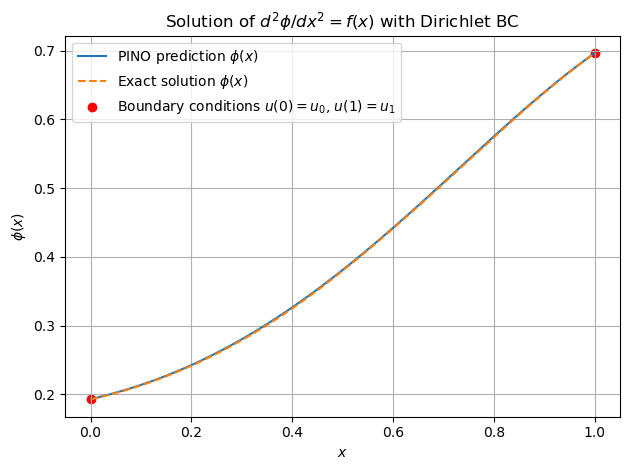

In [7]:
# --- 推論 1 : 学習済み f(x), u0, u1 ---
print("推論 1 : 学習済み f(x), u0, u1")
f_test = f_list[-1]
bc_test = bc_list[-1]

f_sample_test = f_test(x_sample).reshape(-1)
f_input_test = jnp.concatenate([f_sample_test, bc_test])[None, :]
x_plot = jnp.linspace(0, 1, 200).reshape(-1, 1)
u_pred = solver.predict(f_input_test, x_plot)[0]

# --- プロット ---
u_exact_test = solve_poisson_bvp(f_test, bc_test, x_plot)
plt.plot(x_plot[:, 0], u_pred, label=r"PINO prediction $\phi(x)$")
plt.plot(x_plot[:, 0], u_exact_test, '--', label=r"Exact solution $\phi(x)$")
plt.scatter(x_obs[:,0], bc_test, c="r", label=r"Boundary conditions $u(0)=u_0$, $u(1)=u_1$")
plt.xlabel(r"$x$")
plt.ylabel(r"$\phi(x)$")
plt.title(r"Solution of $d^2\phi/dx^2 = f(x)$ with Dirichlet BC")
plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

推論 2 : 初見の f(x), u0, u1


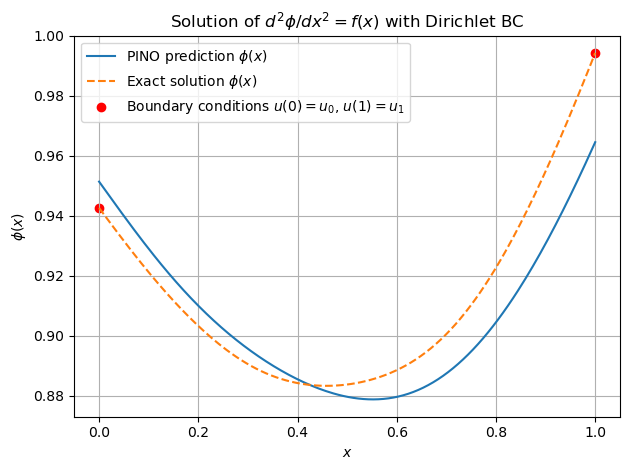

In [8]:
# --- 推論 2 : 初見の f(x), u0, u1 ---
print("推論 2 : 初見の f(x), u0, u1")
f_test = f_unknown
bc_test = bc_unknown


f_sample_test = f_test(x_sample).reshape(-1)
f_input_test = jnp.concatenate([f_sample_test, bc_test])[None, :]
x_plot = jnp.linspace(0, 1, 200).reshape(-1, 1)
u_pred = solver.predict(f_input_test, x_plot)[0]

# --- プロット ---
u_exact_test = solve_poisson_bvp(f_test, bc_test, x_plot)
plt.plot(x_plot[:, 0], u_pred, label=r"PINO prediction $\phi(x)$")
plt.plot(x_plot[:, 0], u_exact_test, '--', label=r"Exact solution $\phi(x)$")
plt.scatter(x_obs[:,0], bc_test, c="r", label=r"Boundary conditions $u(0)=u_0$, $u(1)=u_1$")
plt.xlabel(r"$x$")
plt.ylabel(r"$\phi(x)$")
plt.title(r"Solution of $d^2\phi/dx^2 = f(x)$ with Dirichlet BC")
plt.grid(); plt.legend(); plt.tight_layout(); plt.show()